<a href="https://colab.research.google.com/github/fiedler-m/stock_predictor/blob/main/stock_indicator_data_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import datetime

In [ ]:
!pip install yfinance

# **Importing Stock Data**

The yfinance API is easy and available. For this project, I'll be using the the SPY dataset to train the model. I'm also interested in if the model can be used more broadly on specific stocks. 

In [ ]:
import yfinance as yf

facebook = yf.Ticker("FB")
netflix = yf.Ticker("NFLX")
apple = yf.Ticker("AAPL")
amazon = yf.Ticker("AMZN")
google = yf.Ticker("GOOGL")

In [198]:
spy = 'SPY'
data = yf.Ticker(spy)
stock_data = data.history(period='10y')
stock_data.drop(columns=['Dividends', 'Volume', 'Stock Splits'], inplace=True)
stock_data

,Open,High,Low,Close
Date,,,,
2011-03-17,104.897815,105.217425,104.160251,104.774887
2011-03-18,106.044868,106.077798,104.950184,105.155952
2011-03-21,106.464684,107.007904,106.341215,106.785683
2011-03-22,106.769196,106.909118,106.316503,106.415268
2011-03-23,106.118957,106.999653,105.616894,106.719810
...,...,...,...,...
2021-03-11,392.230011,395.649994,391.739990,393.529999
2021-03-12,392.070007,394.209991,391.200012,394.059998
2021-03-15,394.329987,396.690002,392.029999,396.410004


In [ ]:
netflix = 'NFLX'
netflix_data = yf.Ticker(netflix)
netflix_data = netflix_data.history(period='10y')
netflix_data.drop(columns=['Dividends', 'Volume', 'Stock Splits'], inplace=True)
netflix_data

,Open,High,Low,Close
Date,,,,
2011-03-17,30.991428,31.381430,30.407143,30.557142
2011-03-18,30.508572,30.634287,29.617144,29.914286
2011-03-21,30.264286,30.954287,29.650000,30.405714
2011-03-22,31.538570,31.814285,31.142857,31.627144
2011-03-23,31.721430,32.857143,31.230000,32.722858
...,...,...,...,...
2021-03-11,512.200012,530.239990,510.709991,523.059998
2021-03-12,512.500000,526.510010,506.589996,518.020020
2021-03-15,516.320007,520.729980,508.029999,520.250000


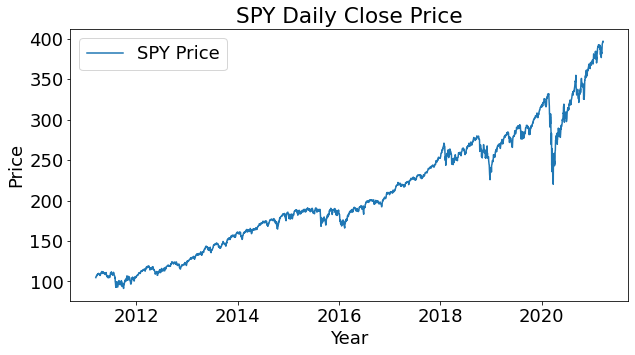

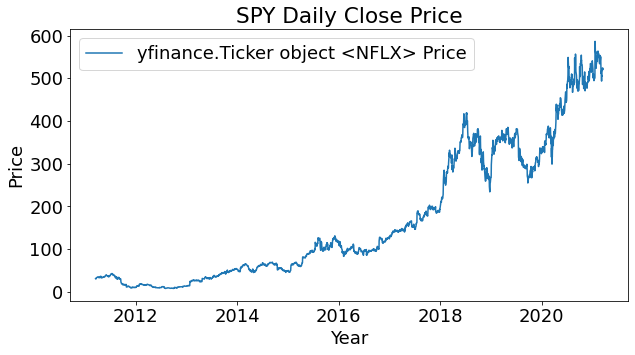

In [199]:
plt.figure(figsize = (10, 5))
plt.plot(stock_data['Close'], label = '%s Price'%spy)
plt.title('SPY Daily Close Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(netflix_data['Close'], label = '%s Price'%netflix)
plt.title('SPY Daily Close Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# **Movement**

The goal here is simply to label upward and downwards movement as it relates to the three week rolling average. The buy and sell signals simply indicate if the price is moving up or down, respectively.

In [200]:
avg_length = 21

stock_data['before_avg'] = stock_data['Close'].rolling(window = avg_length).mean()
stock_data['Buy_signal'] = np.ones(len(stock_data['Close']))

In [201]:
for i in range(0,len(stock_data)):
  after_avg=0
  if i ==(len(stock_data)-avg_length):
    break

  for x in range(0, avg_length):
    after_avg = after_avg + stock_data['Close'].iloc[i+x]
  
  forward_avg = after_avg/avg_length

  if stock_data['before_avg'].iloc[i] < forward_avg:
    stock_data['Buy_signal'].iloc[i] = 1
  else:
    stock_data['Buy_signal'].iloc[i] = 0    

In [202]:
stock_data['Buy_signal'] = stock_data['Buy_signal'].shift(1, axis = 0)

In [ ]:
stock_data

,Open,High,Low,Close,before_avg,Buy_signal
Date,,,,,,
2011-03-17,104.897815,105.217425,104.160251,104.774887,NaN,NaN
2011-03-18,106.044868,106.077798,104.950184,105.155952,NaN,0.0
2011-03-21,106.464684,107.007904,106.341215,106.785683,NaN,0.0
2011-03-22,106.769196,106.909118,106.316503,106.415268,NaN,0.0
2011-03-23,106.118957,106.999653,105.616894,106.719810,NaN,0.0
...,...,...,...,...,...,...
2021-03-11,392.230011,395.649994,391.739990,393.529999,387.510951,1.0
2021-03-12,392.070007,394.209991,391.200012,394.059998,387.700476,1.0
2021-03-15,394.329987,396.690002,392.029999,396.410004,387.971905,1.0


In [203]:
train = stock_data.copy()
test = stock_data.copy()

In [204]:
train['Sell_signal'] = abs(train['Buy_signal'].iloc[:]-1)

In [205]:
train['Buy_price'] = train['Buy_signal'] * train['Close']
train['Sell_price'] = train['Sell_signal'] * train['Close']

train

,Open,High,Low,Close,before_avg,Buy_signal,Sell_signal,Buy_price,Sell_price
Date,,,,,,,,,
2011-03-17,104.897815,105.217425,104.160251,104.774887,NaN,NaN,NaN,NaN,NaN
2011-03-18,106.044868,106.077798,104.950184,105.155952,NaN,0.0,1.0,0.000000,105.155952
2011-03-21,106.464684,107.007904,106.341215,106.785683,NaN,0.0,1.0,0.000000,106.785683
2011-03-22,106.769196,106.909118,106.316503,106.415268,NaN,0.0,1.0,0.000000,106.415268
2011-03-23,106.118957,106.999653,105.616894,106.719810,NaN,0.0,1.0,0.000000,106.719810
...,...,...,...,...,...,...,...,...,...
2021-03-11,392.230011,395.649994,391.739990,393.529999,387.510951,1.0,0.0,393.529999,0.000000
2021-03-12,392.070007,394.209991,391.200012,394.059998,387.700476,1.0,0.0,394.059998,0.000000
2021-03-15,394.329987,396.690002,392.029999,396.410004,387.971905,1.0,0.0,396.410004,0.000000


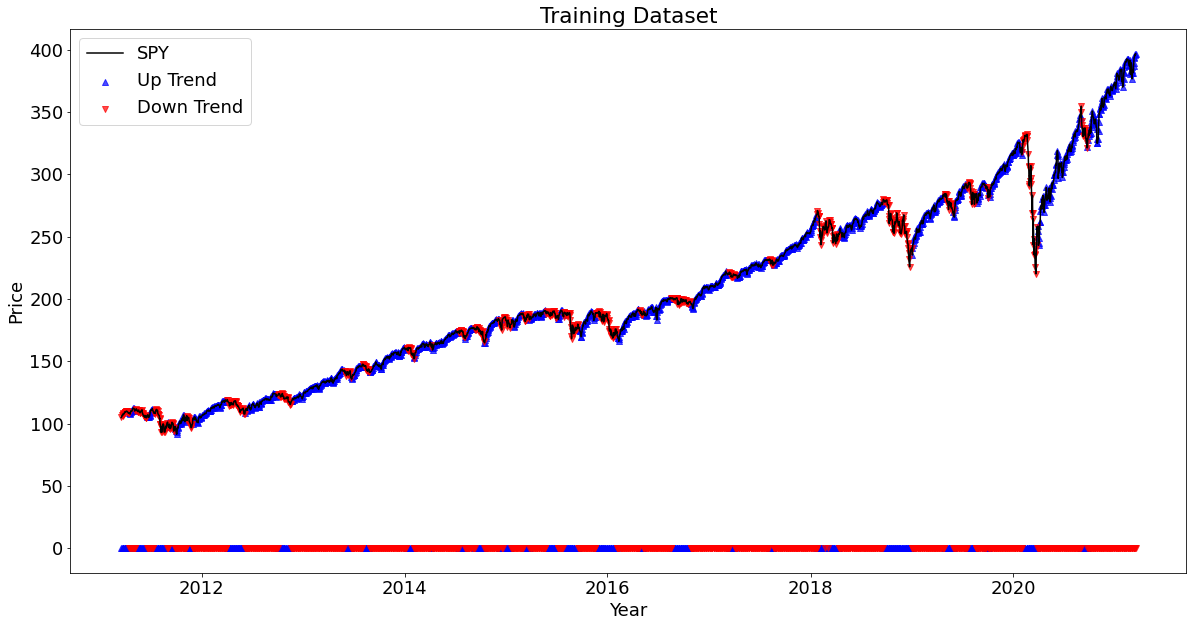

In [206]:
plt.figure(figsize = (20, 10))
ax = plt.axes()
plt.plot(train['Close'], label=spy, color='black')
plt.scatter(train.index, train['Buy_price'], label = 'Up Trend', marker = '^', color = 'blue', alpha = 0.7)
plt.scatter(train.index, train['Sell_price'], label = 'Down Trend', marker = 'v', color = 'red', alpha = 0.7)
plt.title('Training Dataset')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.rcParams.update({'font.size': 18})
plt.show()

# **Stock Price Indicators**

Up until this point, we've only identified which direction a stock is moving at any given time. To create predictors, I'll be using three of the most popular stock indictators: 

*   Relative Strength Index (RSI)
*   Exponential Moving Average (EMA)
*   Williams &R



I won't pretend to be an expert in what these are or how they work, but there's plenty of public documenation available. As I understand it, these are momentum based indicators which will be useful here since I'm building off the foundation of trend based analysis. 

There are dozens of indicators available to traders. My hypothesis is that using a smaller quantity - in this case two - will result in better model performance compared to a larger quantity.  



**Relative Strength Index**

RSI = 100 - (100/1+RS)

RS = Avg Gain/Avg Loss #generally over a 14 day period

In [207]:
gains = [0]
losses = [0]

for i in range(1, len(train)):
  change = train['Close'].iloc[i]-train['Close'].iloc[i-1]
  gains.append(change if change>0 else 0)
  losses.append(abs(change) if change<0 else 0)

train['gains'] = gains
train['losses'] = losses

for i in range(3,31,1):
  x = train['gains'].rolling(window=i).mean()/train['losses'].rolling(window=i).mean()
  rsi = 100-(100/1+x) + 0.001
  train['RSI_%d'%i] = rsi

**Exponential Moving Average**

EMA = Current price (2/(1+N)) + Previous EMA(1-(2/1+N)))

To keep it simple, I'm just going to use the EMA as somewhat of a baseline to determine if the stock is in an upwards or downwards trend.

In [208]:
#EMA
for n in range(3, avg_length*2, 2):
  ema = train['Close'].iloc[0]
  ema_list = [ema]

  for i in range(1, len(train['Close'])):
    ema = train['Close'].iloc[i]*(2/(1+n)) + ema*(1-(2/(1+n)))
    ema_list.append(ema)
  train['EMA'] = ema_list

  ema_slope = [1]
  for x in range(1,len(ema_list)):
    if ema_list[x]<train['Close'].iloc[x]:
      ema_slope.append(1)
    else:
      ema_slope.append(0)
  train['ema_%d'%n] = ema_slope

train.drop(['EMA'], inplace=True, axis=1)

# **Williams %R**

Another momentum indicator. It's main indicator is whether a stock is overbought or oversold. This is meaningful as both a buy/sell signal and possible indicator of trend reversal.  

In [209]:
for i in range(3, avg_length*4, 2):
    High_high = train['High'].rolling(window = i).max()
    Low_low = train['Low'].rolling(window = i).min()
    
    train['Will_R_%d'%i] = -100*(High_high - train['Close'])/(High_high-Low_low)

In [210]:
train.dropna(axis=0, inplace=True)
train.reset_index(inplace=True)
train

,Date,Open,High,Low,Close,before_avg,Buy_signal,Sell_signal,Buy_price,Sell_price,gains,losses,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13,RSI_14,RSI_15,RSI_16,RSI_17,RSI_18,RSI_19,RSI_20,RSI_21,RSI_22,RSI_23,RSI_24,RSI_25,RSI_26,RSI_27,RSI_28,RSI_29,RSI_30,...,Will_R_5,Will_R_7,Will_R_9,Will_R_11,Will_R_13,Will_R_15,Will_R_17,Will_R_19,Will_R_21,Will_R_23,Will_R_25,Will_R_27,Will_R_29,Will_R_31,Will_R_33,Will_R_35,Will_R_37,Will_R_39,Will_R_41,Will_R_43,Will_R_45,Will_R_47,Will_R_49,Will_R_51,Will_R_53,Will_R_55,Will_R_57,Will_R_59,Will_R_61,Will_R_63,Will_R_65,Will_R_67,Will_R_69,Will_R_71,Will_R_73,Will_R_75,Will_R_77,Will_R_79,Will_R_81,Will_R_83
0,2011-07-14,109.325077,109.829642,108.092612,108.299400,107.880119,0.0,1.0,0.000000,108.299400,0.000000,0.752686,-0.296296,-0.111530,-0.089347,-0.374771,-0.407616,-0.398595,-0.790167,-1.041168,-1.264065,-1.599410,-1.826323,-1.405498,-1.329412,-1.193229,-1.422885,-1.508191,-1.557797,-1.594365,-1.225870,-1.388562,-1.398603,-1.184335,-1.267684,-1.211972,-1.204138,-1.083253,-0.988987,-0.979873,...,-94.658069,-95.019919,-95.019919,-78.583305,-52.648954,-50.157643,-50.157643,-50.157643,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454
1,2011-07-15,108.903234,109.076929,108.167066,108.928047,108.088745,0.0,1.0,0.000000,108.928047,0.628647,0.000000,-1.317724,-0.809829,-0.305910,-0.245407,-0.530831,-0.563677,-0.551210,-0.942781,-1.193783,-1.416680,-1.752025,-1.978937,-1.522966,-1.440525,-1.292968,-1.522625,-1.607931,-1.657537,-1.694105,-1.302572,-1.465264,-1.475305,-1.249294,-1.332643,-1.274079,-1.265844,-1.138769,-1.039676,...,-60.235378,-79.880257,-79.880257,-79.880257,-53.970216,-44.162827,-42.165952,-42.165952,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487
2,2011-07-18,108.423478,108.588906,107.224105,108.034714,108.243857,0.0,1.0,0.000000,108.034714,0.000000,0.893333,-0.380920,-0.602021,-0.467755,-0.239483,-0.200680,-0.434296,-0.461180,-0.452795,-0.774580,-0.980848,-1.164020,-1.439600,-1.626072,-1.304965,-1.243951,-1.132336,-1.333483,-1.408199,-1.451647,-1.483675,-1.174452,-1.321153,-1.330208,-1.143633,-1.219938,-1.170671,-1.163714,-1.055426,...,-72.701809,-82.896952,-83.855072,-83.855072,-83.855072,-56.180920,-53.522478,-53.522478,-53.522478,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627
3,2011-07-19,108.638524,109.920617,108.613711,109.788269,108.467582,0.0,1.0,0.000000,109.788269,1.753555,0.000000,-2.665644,-1.446251,-1.667352,-1.295883,-0.664335,-0.556980,-0.790596,-0.817480,-0.802630,-1.124416,-1.330683,-1.513855,-1.789435,-1.975907,-1.585760,-1.511627,-1.376013,-1.577160,-1.651877,-1.695325,-1.727353,-1.367377,-1.514079,-1.523133,-1.309519,-1.385824,-1.329863,-1.321961,...,-13.648769,-13.648769,-48.929422,-48.929422,-48.929422,-39.973226,-32.709350,-31.230358,-31.230358,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.9167

In [ ]:
train.drop(['gains', 'losses', 'High', 'Low', 'before_avg', 'Buy_price', 'Sell_price'], inplace = True, axis =1)

In [217]:
train_data = train.copy()

In [219]:
train_data.drop(['Open'], inplace = True, axis =1)

In [220]:
df_train = train_data.copy()

In [221]:
df_train

,Date,Close,Buy_signal,Sell_signal,RSI_3,RSI_4,RSI_5,RSI_6,RSI_7,RSI_8,RSI_9,RSI_10,RSI_11,RSI_12,RSI_13,RSI_14,RSI_15,RSI_16,RSI_17,RSI_18,RSI_19,RSI_20,RSI_21,RSI_22,RSI_23,RSI_24,RSI_25,RSI_26,RSI_27,RSI_28,RSI_29,RSI_30,ema_3,ema_5,ema_7,ema_9,ema_11,ema_13,ema_15,ema_17,...,Will_R_5,Will_R_7,Will_R_9,Will_R_11,Will_R_13,Will_R_15,Will_R_17,Will_R_19,Will_R_21,Will_R_23,Will_R_25,Will_R_27,Will_R_29,Will_R_31,Will_R_33,Will_R_35,Will_R_37,Will_R_39,Will_R_41,Will_R_43,Will_R_45,Will_R_47,Will_R_49,Will_R_51,Will_R_53,Will_R_55,Will_R_57,Will_R_59,Will_R_61,Will_R_63,Will_R_65,Will_R_67,Will_R_69,Will_R_71,Will_R_73,Will_R_75,Will_R_77,Will_R_79,Will_R_81,Will_R_83
0,2011-07-14,108.299400,0.0,1.0,-0.296296,-0.111530,-0.089347,-0.374771,-0.407616,-0.398595,-0.790167,-1.041168,-1.264065,-1.599410,-1.826323,-1.405498,-1.329412,-1.193229,-1.422885,-1.508191,-1.557797,-1.594365,-1.225870,-1.388562,-1.398603,-1.184335,-1.267684,-1.211972,-1.204138,-1.083253,-0.988987,-0.979873,0,0,0,0,0,0,0,0,...,-94.658069,-95.019919,-95.019919,-78.583305,-52.648954,-50.157643,-50.157643,-50.157643,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-47.684885,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454,-51.573454
1,2011-07-15,108.928047,0.0,1.0,-1.317724,-0.809829,-0.305910,-0.245407,-0.530831,-0.563677,-0.551210,-0.942781,-1.193783,-1.416680,-1.752025,-1.978937,-1.522966,-1.440525,-1.292968,-1.522625,-1.607931,-1.657537,-1.694105,-1.302572,-1.465264,-1.475305,-1.249294,-1.332643,-1.274079,-1.265844,-1.138769,-1.039676,1,0,0,0,0,0,1,1,...,-60.235378,-79.880257,-79.880257,-79.880257,-53.970216,-44.162827,-42.165952,-42.165952,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-40.087183,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487,-44.540487
2,2011-07-18,108.034714,0.0,1.0,-0.380920,-0.602021,-0.467755,-0.239483,-0.200680,-0.434296,-0.461180,-0.452795,-0.774580,-0.980848,-1.164020,-1.439600,-1.626072,-1.304965,-1.243951,-1.132336,-1.333483,-1.408199,-1.451647,-1.483675,-1.174452,-1.321153,-1.330208,-1.143633,-1.219938,-1.170671,-1.163714,-1.055426,0,0,0,0,0,0,0,0,...,-72.701809,-82.896952,-83.855072,-83.855072,-83.855072,-56.180920,-53.522478,-53.522478,-53.522478,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-50.883835,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627,-54.534627
3,2011-07-19,109.788269,0.0,1.0,-2.665644,-1.446251,-1.667352,-1.295883,-0.664335,-0.556980,-0.790596,-0.817480,-0.802630,-1.124416,-1.330683,-1.513855,-1.789435,-1.975907,-1.585760,-1.511627,-1.376013,-1.577160,-1.651877,-1.695325,-1.727353,-1.367377,-1.514079,-1.523133,-1.309519,-1.385824,-1.329863,-1.321961,1,1,1,1,1,1,1,1,...,-13.648769,-13.648769,-48.929422,-48.929422,-48.929422,-39.973226,-32.709350,-31.230358,-31.230358,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-29.690710,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781,-34.916781
4,2011-07-20,109.722115,0.0,1.0,-1.826595,-2.481785,-1.390332,-1.602891,-1.256593,-0.653839,-0.549580,-0.780097,-0.806624,-0.792162,-1.109756,-1.313337,-1.494123,-1.766113,-1.950156,-1.569127,-1.496505,-1.363470,-1.562785,-1.636820,-1.

In [225]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [227]:
df_train.to_csv('Stock_indicators.csv')
!cp Stock_indicators.csv "drive/My Drive/"